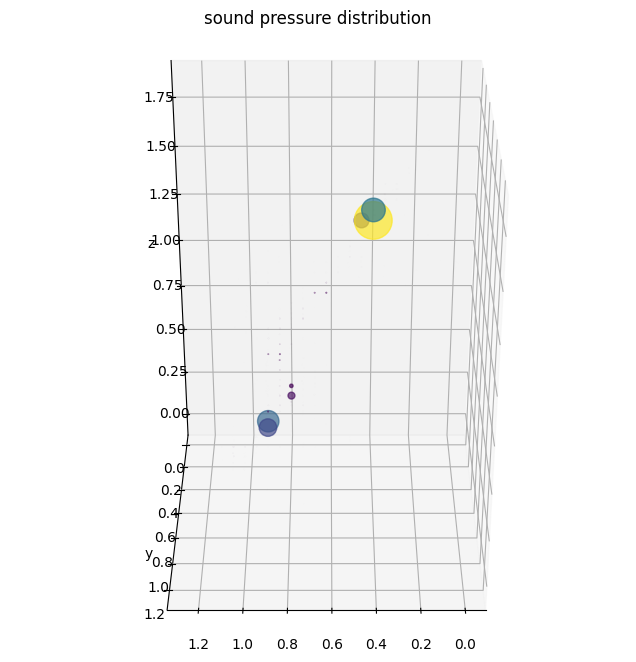

In [131]:
import numpy as np
import acoular as ac
import pyfar as pf
import matplotlib.pyplot as plt

resFileName = "out/2025-01-28_15-59-01_400437_eval_test2"
dotsize = 4
resolution = 0.05

# read Data
result = np.load(resFileName + ".npy")
# start, stop, framerate, frames, frequency_bands, bandwith, resolution, name = pf.io.read(resFileName+".far")
# result_Lp = ac.L_p(result)[4,85]        # convert results in sound pressure Level
# map = result_Lp

map = result[2,41]


a = map.shape[0]

fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, 
             azim=90, 
             roll=0)
ax.set_proj_type('persp', focal_length=0.547)
x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[0]*resolution,map.shape[0]),
                            np.linspace(0,map.shape[1]*resolution,map.shape[1]), 
                            np.linspace(0,map.shape[2]*resolution,map.shape[2]))
ax.scatter(x_m, y_m, z_m, c = map, s = map*10**dotsize)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('sound pressure distribution')
ax.set_aspect('equal')
plt.show()

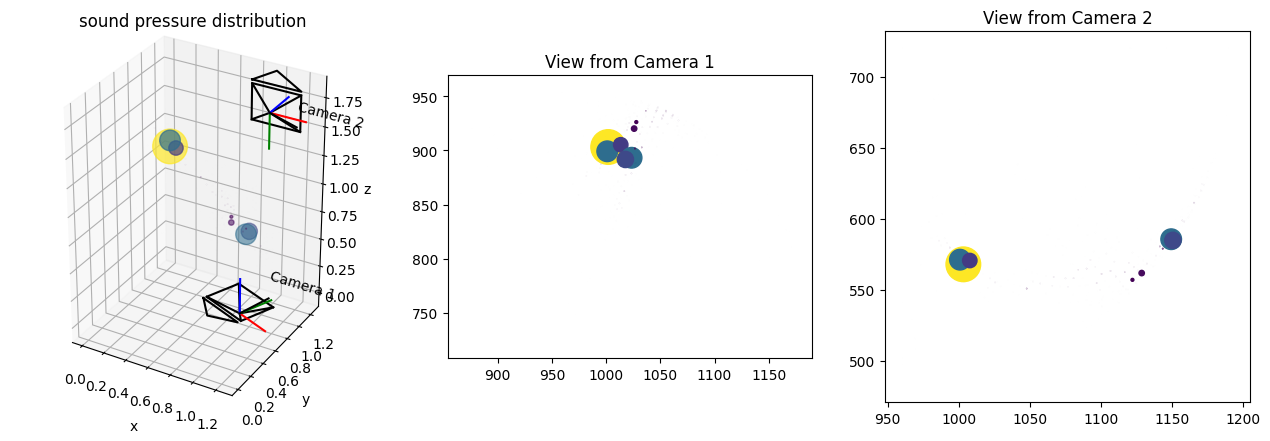

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.rotations import active_matrix_from_intrinsic_euler_xyz
from pytransform3d.transformations import transform_from, plot_transform
from pytransform3d.camera import make_world_grid, world2image, plot_camera, cam2sensor, sensor2img
from pytransform3d.transformations import transform_from, plot_transform


# flatten the pressure map and create a 2D array with the coordinates
x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[0]*resolution,map.shape[0]),
                            np.linspace(0,map.shape[1]*resolution,map.shape[1]),
                            np.linspace(0,map.shape[2]*resolution,map.shape[2]))

x_flat = x_m.ravel()
y_flat = y_m.ravel()
z_flat = z_m.ravel()
pressure_flat = map.ravel()

# Stack the flattened coordinates into a 2D array
coordinates_2d = np.vstack((x_flat, y_flat, z_flat)).T
coordinates_2d_stacked = np.hstack((coordinates_2d, np.array([np.zeros(len(coordinates_2d))]).T))



# Initialize the camera parameters
camera_1_pos = [1.3236992,  0.04429161, 0.52348324]
camera_2_pos = [1.16191888, 0.76769209, 1.82988376]
focal_length = 0.0015
sensor_size = (0.00617, 0.00455)
image_size = (1920, 1440)
intrinsic_camera_matrix = np.array([
    [focal_length,  0,              sensor_size[0] / 2],
    [0,             focal_length,   sensor_size[1] / 2],
    [0,             0,              1]
])

# Define the camera transformation matrices
cam1 = transform_from(active_matrix_from_intrinsic_euler_xyz([0, 0, -0.4]),camera_1_pos)
cam2 = transform_from(active_matrix_from_intrinsic_euler_xyz([np.pi/2, np.pi, np.pi]),camera_2_pos)

# cam_grid = make_world_grid(n_points_per_line=11) - np.array([0, 0, -2, -5])
cam_grid = coordinates_2d
img_grid_3d = cam_grid * focal_length
sensor_grid = cam2sensor(cam_grid, focal_length)
img_grid = sensor2img(sensor_grid, sensor_size, image_size)

# project the 3D points onto the image plane
img_grid1 = world2image(coordinates_2d_stacked, cam1, sensor_size, image_size, focal_length, kappa = 1)
img_grid2 = world2image(coordinates_2d_stacked, cam2, sensor_size, image_size, focal_length, kappa = 1)



# plot the 3D scene
fig = plt.figure(figsize = [16,12])
ax = plt.subplot(131, projection="3d")
# ax.view_init(elev=30, 
#              azim=90, 
#              roll=0)
# ax.set_proj_type('persp', focal_length=0.547)

# plot sond pressure distribution
ax.scatter(x_m,                 y_m,                z_m,                c = map,            s = map*10**dotsize)
# ax.scatter(img_grid_3d[:, 0],   img_grid_3d[:, 1],  img_grid_3d[:, 2],  c = map,            s = map*focal_length*10**dotsize)

# plot and transform cam position 1
plot_camera(ax, intrinsic_camera_matrix, cam1,
            sensor_size=sensor_size, virtual_image_distance=0.1)
plot_transform(ax = ax, A2B = cam1, s = 0.3, name = "Camera 1")

# plot and transform cam position 2
plot_camera(ax, intrinsic_camera_matrix, cam2,
            sensor_size=sensor_size, virtual_image_distance=0.1)
plot_transform(ax = ax, A2B = cam2, s = 0.3, name = "Camera 2")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('sound pressure distribution')
ax.set_aspect('equal')



# plot the 2D image planes
ax = plt.subplot(132, aspect="equal")
ax.set_title("View from Camera 1")
ax.scatter(img_grid1[:, 0], img_grid1[:, 1], c = pressure_flat, s = pressure_flat*10**dotsize)
ax = plt.subplot(133, aspect="equal")
ax.set_title("View from Camera 2")
ax.scatter(img_grid2[:, 0], img_grid2[:, 1], c = pressure_flat, s = pressure_flat*10**dotsize)


plt.show()